In [1]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 + 3 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-03 # Learning rate of the network
test_rate=0.1 # Defines the ratio of training dataset and test dataset
val_rate=0.1
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa / np.max(alpha)

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta)
    
print(bb.shape)

(144, 1)


In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [12]:
hh = hh / np.max(h)

In [13]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [14]:
baseline_coord = data.iloc[:,:].values

In [15]:
standard_coord = baseline_coord.reshape((1, -1))

In [16]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [17]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [18]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [19]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [20]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [21]:
x = np.hstack((aa, hh, bb, total_coords))

In [22]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [23]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [24]:
target_c3 = target_df.iloc[:,3].values # Cd values
target_c4 = target_df.iloc[:,4].values# Cl values

In [25]:
y = np.hstack((target_c3.reshape((-1,1)), target_c4.reshape((-1,1))))

In [26]:
y.shape

(144, 2)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=1)

In [28]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_rate/(1-test_rate), random_state=1)

In [29]:
x_train.shape

(114, 113)

In [30]:
y_train.shape

(114, 2)

In [31]:
tf.keras.backend.set_image_data_format('channels_last')

In [32]:
input_data = tf.keras.Input(shape=(3+total_coords.shape[1]))

x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(input_data)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc4')(x_fc3)
x_fc5 = tf.keras.layers.Dense(units=16, activation='relu', name='fc5')(x_fc4)

output_data = tf.keras.layers.Dense(units=2, activation='linear', name='outputLayer')(x_fc5)
# MLP(FC layer)-based
model = tf.keras.Model(input_data, output_data)

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 113)]             0         
                                                                 
 fc1 (Dense)                 (None, 128)               14592     
                                                                 
 fc2 (Dense)                 (None, 128)               16512     
                                                                 
 fc3 (Dense)                 (None, 128)               16512     
                                                                 
 fc4 (Dense)                 (None, 128)               16512     
                                                                 
 fc5 (Dense)                 (None, 16)                2064      
                                                                 
 outputLayer (Dense)         (None, 2)                 34    

In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [35]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=70, factor=0.5,
                                          min_delta = 1e-07, min_lr=1e-06,
                                          verbose=1)

In [36]:
STEP_SIZE_TRAIN = len(x_train)//batch_size

In [37]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, validation_data=[x_val, y_val], batch_size=batch_size,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    epochs=5000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/5000
5/5 [==============================] - 2s 78ms/step - loss: 0.7172 - rmse: 0.8469 - val_loss: 0.6309 - val_rmse: 0.7943 - lr: 0.0010
Epoch 2/5000
5/5 [==============================] - 0s 11ms/step - loss: 0.4949 - rmse: 0.7035 - val_loss: 0.3768 - val_rmse: 0.6139 - lr: 0.0010
Epoch 3/5000
5/5 [==============================] - 0s 10ms/step - loss: 0.2262 - rmse: 0.4756 - val_loss: 0.0924 - val_rmse: 0.3039 - lr: 0.0010
Epoch 4/5000
5/5 [==============================] - 0s 10ms/step - loss: 0.1191 - rmse: 0.3451 - val_loss: 0.1160 - val_rmse: 0.3406 - lr: 0.0010
Epoch 5/5000
5/5 [==============================] - 0s 10ms/step - loss: 0.1260 - rmse: 0.3549 - val_loss: 0.0565 - val_rmse: 0.2377 - lr: 0.0010
Epoch 6/5000
5/5 [==============================] - 0s 10ms/step - loss: 0.0851 - rmse: 0.2917 - val_loss: 0.0860 - val_rmse: 0.2932 - lr: 0.0010
Epoch 7/5000
5/5 [==============================] - 0s 11ms/step - loss: 0.0775 - rmse: 0.2784 - val_loss: 0.0584 - val_rmse

Epoch 57/5000
5/5 [==============================] - 0s 9ms/step - loss: 0.0111 - rmse: 0.1055 - val_loss: 0.0039 - val_rmse: 0.0625 - lr: 0.0010
Epoch 58/5000
5/5 [==============================] - 0s 10ms/step - loss: 0.0092 - rmse: 0.0961 - val_loss: 0.0066 - val_rmse: 0.0814 - lr: 0.0010
Epoch 59/5000
5/5 [==============================] - 0s 9ms/step - loss: 0.0083 - rmse: 0.0910 - val_loss: 0.0042 - val_rmse: 0.0647 - lr: 0.0010
Epoch 60/5000
5/5 [==============================] - 0s 9ms/step - loss: 0.0091 - rmse: 0.0956 - val_loss: 0.0048 - val_rmse: 0.0694 - lr: 0.0010
Epoch 61/5000
5/5 [==============================] - 0s 10ms/step - loss: 0.0061 - rmse: 0.0781 - val_loss: 0.0047 - val_rmse: 0.0687 - lr: 0.0010
Epoch 62/5000
5/5 [==============================] - 0s 9ms/step - loss: 0.0093 - rmse: 0.0966 - val_loss: 0.0054 - val_rmse: 0.0737 - lr: 0.0010
Epoch 63/5000
5/5 [==============================] - 0s 9ms/step - loss: 0.0072 - rmse: 0.0848 - val_loss: 0.0066 - val_rm

Epoch 113/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.0019 - rmse: 0.0439 - val_loss: 9.4159e-04 - val_rmse: 0.0307 - lr: 0.0010
Epoch 114/5000
5/5 [==============================] - 0s 12ms/step - loss: 0.0011 - rmse: 0.0328 - val_loss: 9.8093e-04 - val_rmse: 0.0313 - lr: 0.0010
Epoch 115/5000
5/5 [==============================] - 0s 12ms/step - loss: 8.8646e-04 - rmse: 0.0298 - val_loss: 8.6445e-04 - val_rmse: 0.0294 - lr: 0.0010
Epoch 116/5000
5/5 [==============================] - 0s 12ms/step - loss: 7.0917e-04 - rmse: 0.0266 - val_loss: 9.1078e-04 - val_rmse: 0.0302 - lr: 0.0010
Epoch 117/5000
5/5 [==============================] - 0s 12ms/step - loss: 7.3787e-04 - rmse: 0.0272 - val_loss: 6.8351e-04 - val_rmse: 0.0261 - lr: 0.0010
Epoch 118/5000
5/5 [==============================] - 0s 13ms/step - loss: 5.5375e-04 - rmse: 0.0235 - val_loss: 8.2695e-04 - val_rmse: 0.0288 - lr: 0.0010
Epoch 119/5000
5/5 [==============================] - 0s 12ms/step - los

5/5 [==============================] - 0s 12ms/step - loss: 3.2655e-04 - rmse: 0.0181 - val_loss: 5.4389e-04 - val_rmse: 0.0233 - lr: 0.0010
Epoch 167/5000
5/5 [==============================] - 0s 12ms/step - loss: 4.2061e-04 - rmse: 0.0205 - val_loss: 4.4622e-04 - val_rmse: 0.0211 - lr: 0.0010
Epoch 168/5000
5/5 [==============================] - 0s 12ms/step - loss: 4.0932e-04 - rmse: 0.0202 - val_loss: 3.3609e-04 - val_rmse: 0.0183 - lr: 0.0010
Epoch 169/5000
5/5 [==============================] - 0s 12ms/step - loss: 3.9665e-04 - rmse: 0.0199 - val_loss: 4.6245e-04 - val_rmse: 0.0215 - lr: 0.0010
Epoch 170/5000
5/5 [==============================] - 0s 12ms/step - loss: 4.5719e-04 - rmse: 0.0214 - val_loss: 4.2070e-04 - val_rmse: 0.0205 - lr: 0.0010
Epoch 171/5000
5/5 [==============================] - 0s 13ms/step - loss: 3.0196e-04 - rmse: 0.0174 - val_loss: 4.2943e-04 - val_rmse: 0.0207 - lr: 0.0010
Epoch 172/5000
5/5 [==============================] - 0s 12ms/step - loss: 3.85

Epoch 219/5000
5/5 [==============================] - 0s 12ms/step - loss: 3.4507e-04 - rmse: 0.0186 - val_loss: 4.8689e-04 - val_rmse: 0.0221 - lr: 0.0010
Epoch 220/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.5402e-04 - rmse: 0.0159 - val_loss: 4.7219e-04 - val_rmse: 0.0217 - lr: 0.0010
Epoch 221/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.7577e-04 - rmse: 0.0133 - val_loss: 3.5847e-04 - val_rmse: 0.0189 - lr: 0.0010
Epoch 222/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.9720e-04 - rmse: 0.0140 - val_loss: 4.3363e-04 - val_rmse: 0.0208 - lr: 0.0010
Epoch 223/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.2282e-04 - rmse: 0.0149 - val_loss: 6.2195e-04 - val_rmse: 0.0249 - lr: 0.0010
Epoch 224/5000
5/5 [==============================] - 0s 12ms/step - loss: 3.5220e-04 - rmse: 0.0188 - val_loss: 4.4388e-04 - val_rmse: 0.0211 - lr: 0.0010
Epoch 225/5000
5/5 [==============================] - 0s 12ms/st

5/5 [==============================] - 0s 13ms/step - loss: 2.6309e-04 - rmse: 0.0162 - val_loss: 2.2198e-04 - val_rmse: 0.0149 - lr: 0.0010
Epoch 272/5000
5/5 [==============================] - 0s 13ms/step - loss: 1.8142e-04 - rmse: 0.0135 - val_loss: 3.2412e-04 - val_rmse: 0.0180 - lr: 0.0010
Epoch 273/5000
5/5 [==============================] - 0s 12ms/step - loss: 3.5884e-04 - rmse: 0.0189 - val_loss: 2.7982e-04 - val_rmse: 0.0167 - lr: 0.0010
Epoch 274/5000
5/5 [==============================] - 0s 13ms/step - loss: 3.6892e-04 - rmse: 0.0192 - val_loss: 5.0148e-04 - val_rmse: 0.0224 - lr: 0.0010
Epoch 275/5000
5/5 [==============================] - 0s 12ms/step - loss: 4.1334e-04 - rmse: 0.0203 - val_loss: 6.8294e-04 - val_rmse: 0.0261 - lr: 0.0010
Epoch 276/5000
5/5 [==============================] - 0s 12ms/step - loss: 4.1805e-04 - rmse: 0.0204 - val_loss: 4.4316e-04 - val_rmse: 0.0211 - lr: 0.0010
Epoch 277/5000
5/5 [==============================] - 0s 12ms/step - loss: 4.55

5/5 [==============================] - 0s 12ms/step - loss: 1.2593e-04 - rmse: 0.0112 - val_loss: 3.8143e-04 - val_rmse: 0.0195 - lr: 5.0000e-04
Epoch 324/5000
5/5 [==============================] - 0s 12ms/step - loss: 8.6468e-05 - rmse: 0.0093 - val_loss: 3.6013e-04 - val_rmse: 0.0190 - lr: 5.0000e-04
Epoch 325/5000
5/5 [==============================] - 0s 12ms/step - loss: 9.4187e-05 - rmse: 0.0097 - val_loss: 3.7228e-04 - val_rmse: 0.0193 - lr: 5.0000e-04
Epoch 326/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.1351e-04 - rmse: 0.0107 - val_loss: 4.5585e-04 - val_rmse: 0.0214 - lr: 5.0000e-04
Epoch 327/5000
5/5 [==============================] - 0s 12ms/step - loss: 8.2522e-05 - rmse: 0.0091 - val_loss: 2.9615e-04 - val_rmse: 0.0172 - lr: 5.0000e-04
Epoch 328/5000
5/5 [==============================] - 0s 11ms/step - loss: 1.1867e-04 - rmse: 0.0109 - val_loss: 3.0457e-04 - val_rmse: 0.0175 - lr: 5.0000e-04
Epoch 329/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 13ms/step - loss: 6.1420e-05 - rmse: 0.0078 - val_loss: 2.7949e-04 - val_rmse: 0.0167 - lr: 5.0000e-04
Epoch 375/5000
5/5 [==============================] - 0s 12ms/step - loss: 8.6460e-05 - rmse: 0.0093 - val_loss: 2.6955e-04 - val_rmse: 0.0164 - lr: 5.0000e-04
Epoch 376/5000
5/5 [==============================] - 0s 12ms/step - loss: 6.3663e-05 - rmse: 0.0080 - val_loss: 3.1949e-04 - val_rmse: 0.0179 - lr: 5.0000e-04
Epoch 377/5000
5/5 [==============================] - 0s 12ms/step - loss: 7.1561e-05 - rmse: 0.0085 - val_loss: 4.0820e-04 - val_rmse: 0.0202 - lr: 5.0000e-04
Epoch 378/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.0849e-04 - rmse: 0.0104 - val_loss: 2.9359e-04 - val_rmse: 0.0171 - lr: 5.0000e-04
Epoch 379/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.9654e-04 - rmse: 0.0140 - val_loss: 4.5851e-04 - val_rmse: 0.0214 - lr: 5.0000e-04
Epoch 380/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 13ms/step - loss: 5.0410e-05 - rmse: 0.0071 - val_loss: 1.8682e-04 - val_rmse: 0.0137 - lr: 5.0000e-04
Epoch 426/5000
5/5 [==============================] - 0s 12ms/step - loss: 6.5608e-05 - rmse: 0.0081 - val_loss: 2.7203e-04 - val_rmse: 0.0165 - lr: 5.0000e-04
Epoch 427/5000
5/5 [==============================] - 0s 12ms/step - loss: 8.8955e-05 - rmse: 0.0094 - val_loss: 2.3986e-04 - val_rmse: 0.0155 - lr: 5.0000e-04
Epoch 428/5000
5/5 [==============================] - 0s 12ms/step - loss: 8.9361e-05 - rmse: 0.0095 - val_loss: 3.5786e-04 - val_rmse: 0.0189 - lr: 5.0000e-04
Epoch 429/5000
5/5 [==============================] - 0s 12ms/step - loss: 7.4673e-05 - rmse: 0.0086 - val_loss: 2.7616e-04 - val_rmse: 0.0166 - lr: 5.0000e-04
Epoch 430/5000
5/5 [==============================] - 0s 12ms/step - loss: 5.3427e-05 - rmse: 0.0073 - val_loss: 2.3162e-04 - val_rmse: 0.0152 - lr: 5.0000e-04
Epoch 431/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 12ms/step - loss: 3.3375e-05 - rmse: 0.0058 - val_loss: 2.1030e-04 - val_rmse: 0.0145 - lr: 5.0000e-04
Epoch 477/5000
5/5 [==============================] - 0s 13ms/step - loss: 2.0791e-05 - rmse: 0.0046 - val_loss: 2.2384e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 478/5000
5/5 [==============================] - 0s 12ms/step - loss: 3.2058e-05 - rmse: 0.0057 - val_loss: 2.3508e-04 - val_rmse: 0.0153 - lr: 5.0000e-04
Epoch 479/5000
5/5 [==============================] - 0s 13ms/step - loss: 1.5984e-05 - rmse: 0.0040 - val_loss: 2.1556e-04 - val_rmse: 0.0147 - lr: 5.0000e-04
Epoch 480/5000
5/5 [==============================] - 0s 13ms/step - loss: 2.8805e-05 - rmse: 0.0054 - val_loss: 2.4414e-04 - val_rmse: 0.0156 - lr: 5.0000e-04
Epoch 481/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.3782e-05 - rmse: 0.0049 - val_loss: 2.3912e-04 - val_rmse: 0.0155 - lr: 5.0000e-04
Epoch 482/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 13ms/step - loss: 8.8647e-05 - rmse: 0.0094 - val_loss: 2.9756e-04 - val_rmse: 0.0173 - lr: 5.0000e-04
Epoch 528/5000
5/5 [==============================] - 0s 12ms/step - loss: 5.7816e-05 - rmse: 0.0076 - val_loss: 2.5893e-04 - val_rmse: 0.0161 - lr: 5.0000e-04
Epoch 529/5000
5/5 [==============================] - 0s 12ms/step - loss: 5.1719e-05 - rmse: 0.0072 - val_loss: 2.7150e-04 - val_rmse: 0.0165 - lr: 5.0000e-04
Epoch 530/5000
5/5 [==============================] - 0s 12ms/step - loss: 3.8815e-05 - rmse: 0.0062 - val_loss: 3.2552e-04 - val_rmse: 0.0180 - lr: 5.0000e-04
Epoch 531/5000
5/5 [==============================] - 0s 12ms/step - loss: 3.8499e-05 - rmse: 0.0062 - val_loss: 2.0099e-04 - val_rmse: 0.0142 - lr: 5.0000e-04
Epoch 532/5000
5/5 [==============================] - 0s 13ms/step - loss: 3.6941e-05 - rmse: 0.0061 - val_loss: 2.3536e-04 - val_rmse: 0.0153 - lr: 5.0000e-04
Epoch 533/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 12ms/step - loss: 1.3983e-05 - rmse: 0.0037 - val_loss: 2.4095e-04 - val_rmse: 0.0155 - lr: 2.5000e-04
Epoch 578/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.0543e-05 - rmse: 0.0032 - val_loss: 2.2114e-04 - val_rmse: 0.0149 - lr: 2.5000e-04
Epoch 579/5000
5/5 [==============================] - 0s 13ms/step - loss: 1.1095e-05 - rmse: 0.0033 - val_loss: 2.4536e-04 - val_rmse: 0.0157 - lr: 2.5000e-04
Epoch 580/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.0831e-05 - rmse: 0.0033 - val_loss: 2.5789e-04 - val_rmse: 0.0161 - lr: 2.5000e-04
Epoch 581/5000
5/5 [==============================] - 0s 13ms/step - loss: 1.1990e-05 - rmse: 0.0035 - val_loss: 2.2444e-04 - val_rmse: 0.0150 - lr: 2.5000e-04
Epoch 582/5000
5/5 [==============================] - 0s 13ms/step - loss: 9.3337e-06 - rmse: 0.0031 - val_loss: 2.4343e-04 - val_rmse: 0.0156 - lr: 2.5000e-04
Epoch 583/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 12ms/step - loss: 1.3188e-05 - rmse: 0.0036 - val_loss: 2.2443e-04 - val_rmse: 0.0150 - lr: 2.5000e-04
Epoch 629/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.0986e-05 - rmse: 0.0033 - val_loss: 2.2633e-04 - val_rmse: 0.0150 - lr: 2.5000e-04
Epoch 630/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.1774e-05 - rmse: 0.0034 - val_loss: 2.2972e-04 - val_rmse: 0.0152 - lr: 2.5000e-04
Epoch 631/5000
5/5 [==============================] - 0s 12ms/step - loss: 8.6510e-06 - rmse: 0.0029 - val_loss: 2.1909e-04 - val_rmse: 0.0148 - lr: 2.5000e-04
Epoch 632/5000
5/5 [==============================] - 0s 12ms/step - loss: 9.9092e-06 - rmse: 0.0031 - val_loss: 2.2653e-04 - val_rmse: 0.0151 - lr: 2.5000e-04
Epoch 633/5000
5/5 [==============================] - 0s 13ms/step - loss: 7.6967e-06 - rmse: 0.0028 - val_loss: 2.5074e-04 - val_rmse: 0.0158 - lr: 2.5000e-04
Epoch 634/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 12ms/step - loss: 9.2279e-06 - rmse: 0.0030 - val_loss: 2.3402e-04 - val_rmse: 0.0153 - lr: 2.5000e-04
Epoch 680/5000
5/5 [==============================] - 0s 12ms/step - loss: 9.5758e-06 - rmse: 0.0031 - val_loss: 2.3947e-04 - val_rmse: 0.0155 - lr: 2.5000e-04
Epoch 681/5000
5/5 [==============================] - 0s 12ms/step - loss: 6.8610e-06 - rmse: 0.0026 - val_loss: 2.3210e-04 - val_rmse: 0.0152 - lr: 2.5000e-04
Epoch 682/5000
5/5 [==============================] - 0s 12ms/step - loss: 7.0919e-06 - rmse: 0.0027 - val_loss: 2.3363e-04 - val_rmse: 0.0153 - lr: 2.5000e-04
Epoch 683/5000
5/5 [==============================] - 0s 12ms/step - loss: 8.5427e-06 - rmse: 0.0029 - val_loss: 2.4459e-04 - val_rmse: 0.0156 - lr: 2.5000e-04
Epoch 684/5000
5/5 [==============================] - 0s 12ms/step - loss: 8.6215e-06 - rmse: 0.0029 - val_loss: 2.5144e-04 - val_rmse: 0.0159 - lr: 2.5000e-04
Epoch 685/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 12ms/step - loss: 7.9038e-06 - rmse: 0.0028 - val_loss: 2.3714e-04 - val_rmse: 0.0154 - lr: 2.5000e-04
Epoch 731/5000
5/5 [==============================] - 0s 12ms/step - loss: 7.8462e-06 - rmse: 0.0028 - val_loss: 2.3376e-04 - val_rmse: 0.0153 - lr: 2.5000e-04
Epoch 732/5000
5/5 [==============================] - 0s 12ms/step - loss: 8.4556e-06 - rmse: 0.0029 - val_loss: 2.1363e-04 - val_rmse: 0.0146 - lr: 2.5000e-04
Epoch 733/5000
5/5 [==============================] - 0s 12ms/step - loss: 7.3594e-06 - rmse: 0.0027 - val_loss: 2.2479e-04 - val_rmse: 0.0150 - lr: 2.5000e-04
Epoch 734/5000
5/5 [==============================] - 0s 12ms/step - loss: 7.9853e-06 - rmse: 0.0028 - val_loss: 2.2762e-04 - val_rmse: 0.0151 - lr: 2.5000e-04
Epoch 735/5000
5/5 [==============================] - 0s 12ms/step - loss: 6.2765e-06 - rmse: 0.0025 - val_loss: 2.4225e-04 - val_rmse: 0.0156 - lr: 2.5000e-04
Epoch 736/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 12ms/step - loss: 8.5960e-06 - rmse: 0.0029 - val_loss: 2.1078e-04 - val_rmse: 0.0145 - lr: 2.5000e-04
Epoch 782/5000
5/5 [==============================] - 0s 12ms/step - loss: 6.2534e-06 - rmse: 0.0025 - val_loss: 2.3153e-04 - val_rmse: 0.0152 - lr: 2.5000e-04
Epoch 783/5000
5/5 [==============================] - 0s 12ms/step - loss: 7.4220e-06 - rmse: 0.0027 - val_loss: 2.1895e-04 - val_rmse: 0.0148 - lr: 2.5000e-04
Epoch 784/5000
5/5 [==============================] - 0s 12ms/step - loss: 5.5873e-06 - rmse: 0.0024 - val_loss: 2.4528e-04 - val_rmse: 0.0157 - lr: 2.5000e-04
Epoch 785/5000
5/5 [==============================] - 0s 13ms/step - loss: 6.8084e-06 - rmse: 0.0026 - val_loss: 2.0908e-04 - val_rmse: 0.0145 - lr: 2.5000e-04
Epoch 786/5000
5/5 [==============================] - 0s 12ms/step - loss: 6.6839e-06 - rmse: 0.0026 - val_loss: 2.7088e-04 - val_rmse: 0.0165 - lr: 2.5000e-04
Epoch 787/5000
5/5 [==============================] - 0

In [38]:
time = end - start
print("Training time:", time)

Training time: 0:00:46.321713


In [39]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221120MLP_revised\\val_"+str(val_rate)+'_'+str(test_rate)
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

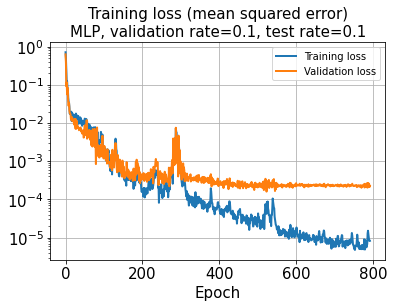

In [46]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.plot(hist['val_loss'], lw=2)
plt.title('Training loss (mean squared error)\nMLP, validation rate={0}, test rate={1}'.format(val_rate, test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(['Training loss','Validation loss'])
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

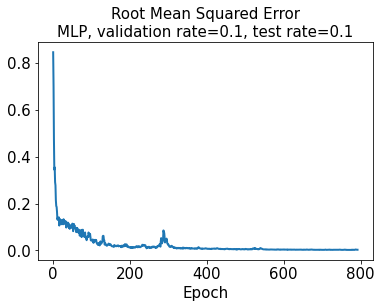

In [47]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error\nMLP, validation rate={0}, test rate={1}'.format(val_rate, test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

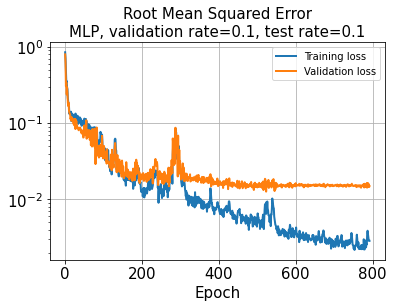

In [48]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error\nMLP, validation rate={0}, test rate={1}'.format(val_rate, test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(['Training loss','Validation loss'])
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [43]:
train_results = model.evaluate(x_train, y_train)

4/4 [==============================] - 0s 3ms/step - loss: 7.4025e-06 - rmse: 0.0027


In [44]:
test_results = model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 19ms/step - loss: 7.0970e-05 - rmse: 0.0084


In [49]:
decoded_train = model.predict(x_train)
decoded_val = model.predict(x_val)
decoded_test = model.predict(x_test)

1/1 [==============================] - 0s 14ms/step


In [50]:
model_directory = "D:\\TrainedModels\\20221119"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221119steadyValidation_MLP_val"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_units) +"units_normalized.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [51]:
error_train_abs = np.abs(decoded_train - y_train)

In [53]:
error_val_abs = np.abs(decoded_val - y_val)

In [54]:
error_test_abs = np.abs(decoded_test - y_test)

In [55]:
os.chdir(storage_dir)

In [56]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.0031972238114523835


In [57]:
l2_error_val = np.sqrt(np.sum((decoded_val - y_val)**2) / np.sum(y_val**2))
print(l2_error_val)

0.01753519342433445


In [58]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.009736465629930545


In [59]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,0] - y_train[:,0])**2) / np.sum(y_train[:,0]**2))
print(l2_error_Cd_train)

0.03341730144580604


In [60]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,1] - y_train[:,1])**2) / np.sum(y_train[:,1]**2))
print(l2_error_Cl_train)

0.0029465351379821558


In [61]:
l2_error_Cd_val = np.sqrt(np.sum((decoded_val[:,0] - y_val[:,0])**2) / np.sum(y_val[:,0]**2))
print(l2_error_Cd_val)

0.07261089925011897


In [62]:
l2_error_Cl_val = np.sqrt(np.sum((decoded_val[:,1] - y_val[:,1])**2) / np.sum(y_val[:,1]**2))
print(l2_error_Cl_val)

0.017370743746539328


In [63]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,0] - y_test[:,0])**2) / np.sum(y_test[:,0]**2))
print(l2_error_Cd_test)

0.055028864190276375


In [64]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,1] - y_test[:,1])**2) / np.sum(y_test[:,1]**2))
print(l2_error_Cl_test)

0.009583304536714748


In [65]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [66]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = np.sqrt(np.sum((decoded_val[i] - y_val[i])**2) / np.sum(y_val[i]**2))
    l2_error_val_list.append(l2_error_val_data)

In [67]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

In [68]:
l2_error_train_Cd_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cd_data = np.sqrt(np.sum((decoded_train[i][0] - y_train[i][0])**2) / np.sum(y_train[i][0]**2))
    l2_error_train_Cd_list.append(l2_error_train_Cd_data)

In [69]:
l2_error_train_Cl_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cl_data = np.sqrt(np.sum((decoded_train[i][1] - y_train[i][1])**2) / np.sum(y_train[i][1]**2))
    l2_error_train_Cl_list.append(l2_error_train_Cl_data)

In [70]:
l2_error_val_Cd_list = []
for i in range(0, len(x_val)):
    l2_error_val_Cd_data = np.sqrt(np.sum((decoded_val[i][0] - y_val[i][0])**2) / np.sum(y_val[i][0]**2))
    l2_error_val_Cd_list.append(l2_error_val_Cd_data)

In [71]:
l2_error_val_Cl_list = []
for i in range(0, len(x_val)):
    l2_error_val_Cl_data = np.sqrt(np.sum((decoded_val[i][1] - y_val[i][1])**2) / np.sum(y_val[i][1]**2))
    l2_error_val_Cl_list.append(l2_error_val_Cl_data)

In [72]:
l2_error_test_Cd_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cd_data = np.sqrt(np.sum((decoded_test[i][0] - y_test[i][0])**2) / np.sum(y_test[i][0]**2))
    l2_error_test_Cd_list.append(l2_error_test_Cd_data)

In [73]:
l2_error_test_Cl_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cl_data = np.sqrt(np.sum((decoded_test[i][1] - y_test[i][1])**2) / np.sum(y_test[i][1]**2))
    l2_error_test_Cl_list.append(l2_error_test_Cl_data)

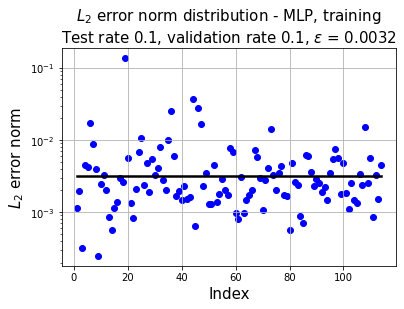

In [74]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\nTest rate {0}, validation rate {1}, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                            val_rate,
                                                                                                                            l2_error_train), fontsize=15)
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

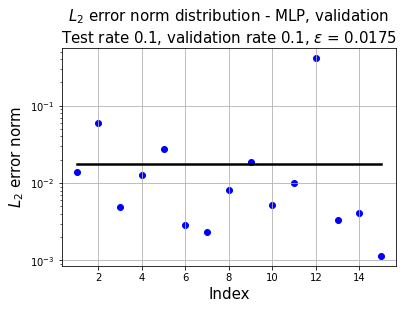

In [75]:
plt.plot(np.linspace(1,x_val.shape[0],x_val.shape[0]),
         l2_error_val*np.ones(x_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_val.shape[0], x_val.shape[0]), l2_error_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, validation\nTest rate {0}, validation rate {1}, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                              val_rate,
                                                                                                                              l2_error_val), fontsize=15)
plt.grid()
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

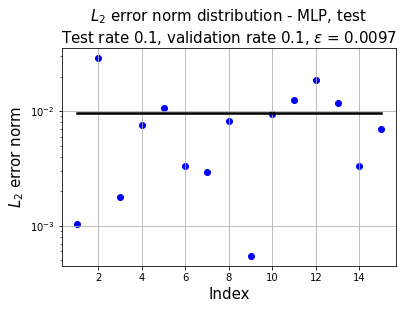

In [76]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\nTest rate {0}, validation rate {1}, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                        val_rate,
                                                                                                                        l2_error_test), fontsize=15)
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

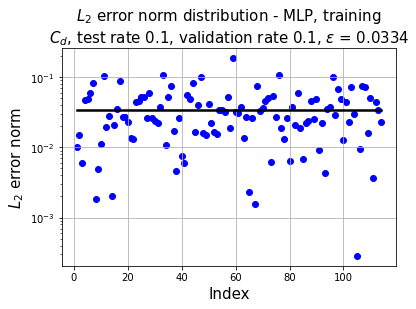

In [77]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cd_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\n$C_d$, test rate {0}, validation rate {1}, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                                   val_rate,
                                                                                                                                   l2_error_Cd_train), fontsize=15)
plt.grid()
saveName = "CdtrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

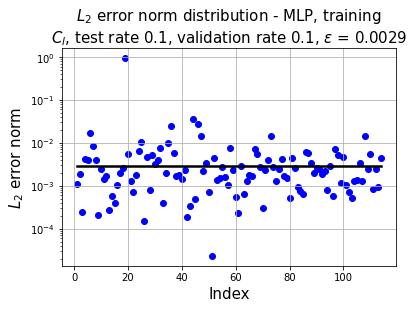

In [78]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cl_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\n$C_l$, test rate {0}, validation rate {1}, $\epsilon$ = {2:0.4f}'.format(test_rate, 
                                                                                                                                   val_rate,
                                                                                                                                   l2_error_Cl_train), fontsize=15)
plt.grid()
saveName = "CltrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

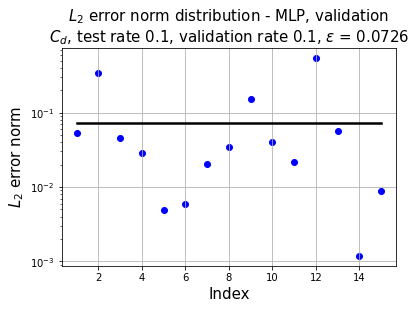

In [79]:
plt.plot(np.linspace(1,x_val.shape[0],x_val.shape[0]),
         l2_error_Cd_val*np.ones(x_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_val.shape[0], x_val.shape[0]), l2_error_val_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, validation\n$C_d$, test rate {0}, validation rate {1}, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                                     val_rate,
                                                                                                                                     l2_error_Cd_val), fontsize=15)
plt.grid()
saveName = "CdvalidationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

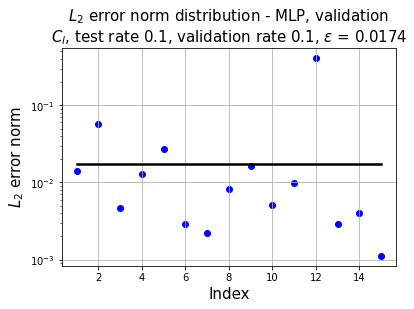

In [80]:
plt.plot(np.linspace(1,x_val.shape[0],x_val.shape[0]),
         l2_error_Cl_val*np.ones(x_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_val.shape[0], x_val.shape[0]), l2_error_val_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, validation\n$C_l$, test rate {0}, validation rate {1}, $\epsilon$ = {2:0.4f}'.format(test_rate, 
                                                                                                                                   val_rate,
                                                                                                                                   l2_error_Cl_val), fontsize=15)
plt.grid()
saveName = "ClvalidationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

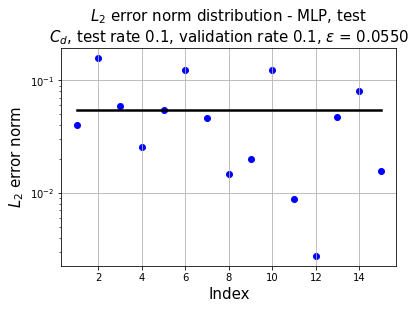

In [81]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cd_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\n$C_d$, test rate {0}, validation rate {1}, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                               val_rate,
                                                                                                                               l2_error_Cd_test), fontsize=15)
plt.grid()
saveName = "CdtestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

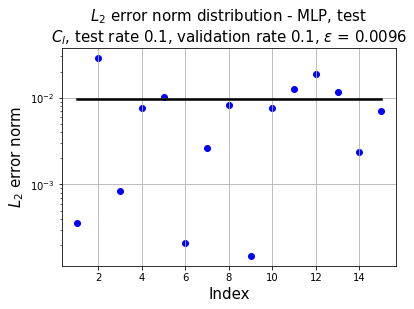

In [82]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cl_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\n$C_l$, test rate {0}, validation rate {1}, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                               val_rate,
                                                                                                                               l2_error_Cl_test), fontsize=15)
plt.grid()
saveName = "CltestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()